## Binary classification with CRNN

The paths utilized are defiend in the `path_module.py`

Before this, the data must be processed. 
- `data_processing` notebook loads raw data and prepares training,validation and test dataset

### 1. Import libraries

In [1]:
from modules.path_module import *
from modules.utils_module import *
import os
import joblib
import torch
import numpy as np
import matplotlib.pyplot as plt

### 2. Load data

In [2]:
train_data=joblib.load(os.path.join(processed_datapath,"train_data.joblib"))
test_data=joblib.load(os.path.join(processed_datapath,"test_data.joblib"))
val_data=joblib.load(os.path.join(processed_datapath,"val_data.joblib"))

### 3. Prepare data
- We train using the training set and save the model that gives the best performance on the validation set

In [3]:
train_sigdata,train_label=prepare_cnn_data(train_data)
val_sigdata,val_label=prepare_cnn_data(val_data)
test_sigdata,test_label=prepare_cnn_data(test_data)

### 4. CRNN model

CNN+GRU paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8528094/


Model:

| Layer                  | Number of filters | Kernel size | Stride | Output shape | Number of parameters | Regularization |
|------------------------|-------------------|-------------|--------|--------------|----------------------|----------------|
| Input                  | –                 | –           | –      | (2500, 59)   | 0                    | –              |
| 1D convolution         | 32                | 3           | 1      | (2498, 32)   | 5,728                | –              |
| Max-pooling            | 32                | 3           | 2      | (1249, 32)   | 0                    | Dropout (0.5)  |
| 1D convolution         | 64                | 3           | 1      | (1247, 64)   | 6,208                | –              |
| Max-pooling            | 64                | 3           | 2      | (623, 64)    | 0                    | Dropout (0.5)  |
| GRU                    | 35                | –           | –      | (623, 35)    | 10,500               | –              |
| Time distributed       | 35                | –           | –      | (623, 35)    | 1,260                | –              |
| Global average pooling | 35                | –           | –      | (1, 35)      | 0                    | –              |
| Dense                  | 35                | –           | –      | (1, 2)       | 72                   | –              |
| **Total**              |                   |             |        |              | **23,768**           |                |


1. **Input Layer**: The input shape is now (2500, 59).
2. **1D Convolution Layer**: 
   - Output shape is calculated using the formula: \( \text{Output length} = \left( \frac{\text{Input length} - \text{Kernel size}}{\text{Stride}} \right) + 1 \)
   - Parameters: \((\text{Kernel size} \times \text{Input channels} + \text{Bias}) \times \text{Number of filters}\)
   - New output shape: \( (2500 - 3 + 1) = 2498 \)
   - Parameters: \((3 \times 59 + 1) \times 32 = 5,728\)
3. **Max-Pooling Layer**:
   - Output shape: \((2498 - 3) / 2 + 1 = 1249\)
   - No parameters.
4. **1D Convolution Layer**:
   - Output shape: \( (1249 - 3 + 1) = 1247 \)
   - Parameters: \((3 \times 32 + 1) \times 64 = 6,208\)
5. **Max-Pooling Layer**:
   - Output shape: \((1247 - 3) / 2 + 1 = 623\)
   - No parameters.
6. **GRU Layer**:
   - The GRU output shape remains (623, 35) since it depends on the number of GRU units.
   - Parameters: GRU units parameters calculation.
7. **Time Distributed Layer**:
   - A Keras wrapper that applies a dense layer (input x input) in each temporal slice. So, it is 35 by 35 dense layer which is applied to all temporal slice.
8. **Global Average Pooling Layer**:
   - Output shape: (1, 35)
   - No parameters.
9. **Dense Layer**:
   - Output shape: (1, 2)
   - Parameters: \((35 + 1) \times 2 = 72\)


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class CRNN_Model(nn.Module):
    def __init__(self,chan_total,signal_length):
        super(CRNN_Model,self).__init__()

        self.conv1=nn.Conv1d(in_channels=chan_total,out_channels=32,kernel_size=3,stride=1,padding=0)
        self.pool=nn.MaxPool1d(kernel_size=3,stride=2)
        self.conv2=nn.Conv1d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0)
        self.gru=nn.GRU(input_size=64,hidden_size=35,batch_first=True)
        self.time_distributed = nn.Linear(35, 35)
        self.global_pool=nn.AdaptiveAvgPool1d(1)
        self.fc=nn.Linear(35,2)
        self.dropout = nn.Dropout(0.5)

    def forward(self,x):# input batch x chan x signal
        x=self.conv1(x)
        x=self.pool(x)
        x=F.relu(x)
        x=self.dropout(x)
        
        x=self.conv2(x)
        x=self.pool(x)
        x=F.relu(x)
        x=self.dropout(x)
        

        #gru needs batch x signal x chan
        x=x.permute(0,2,1)
        x,_=self.gru(x)
        x = self.time_distributed(x)
        x = F.relu(x)

        # we need to apply gobal avg for each time slice. so we changed to: batch  x chan x signal
        x=x.permute(0,2,1)
        x=self.global_pool(x)
        x = x.squeeze(2)  # Remove the sequence_length dimension
        x=self.fc(x)
        return x 

### 5. Initialize model

In [5]:
import torch.optim as optim
from torch import cuda

# Set the random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

# use GPU
device='cpu'#'cuda' if cuda.is_available() else 'cpu'
print("Running on: "+device)
cuda.empty_cache()

# initialize model
n_chan=train_data[0].data.shape[1]
n_datalength=train_data[0].data.shape[0]
model = CRNN_Model(n_chan,n_datalength)
model.to(device)
print('Model created')

Running on: cpu
Model created


### 6. Configure Training

In [6]:
batch_size = 64 # from paper
num_epochs = 100 # from paper
lrate=1e-3 #from paper
patience=100 # no early stopping from paper
# Define loss function and optimizer
criterion = nn.BCELoss() # from paper
optimizer = optim.Adam(model.parameters(), lr=lrate) # from paper
cnn_modelfullpath=os.path.join(cnn_modelpath,'crnn.pt')
random_seed=42

training_arg={
    'modelfullpath': cnn_modelfullpath,
    'criterion': criterion,
    'optimizer': optimizer,
    'epochs': num_epochs,
    'patience': patience,
    'seed': random_seed
}

### 7. Prepare data

In [7]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.stack(train_sigdata), torch.stack(train_label))
val_dataset = TensorDataset(torch.stack(val_sigdata), torch.stack(val_label))
test_dataset = TensorDataset(torch.stack(test_sigdata), torch.stack(test_label))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### 8. Train model

In [8]:
results= model_trainer(model,train_loader,val_loader,training_arg)

Epoch 1/100: 100%|██████████| 6/6 [00:03<00:00,  1.70it/s]


model state saved with validation accuracy: 52.1739


Epoch 2/100: 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


model state saved with validation accuracy: 54.3478


Epoch 3/100: 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


model state saved with validation accuracy: 57.2464


Epoch 8/100: 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


model state saved with validation accuracy: 61.5942


Epoch 9/100: 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


model state saved with validation accuracy: 63.7681


Epoch 10/100: 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


model state saved with validation accuracy: 66.6667


Epoch 16/100: 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


model state saved with validation accuracy: 69.5652


Epoch 17/100: 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


model state saved with validation accuracy: 70.2899


Epoch 19/100: 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


model state saved with validation accuracy: 71.0145


Epoch 22/100: 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


model state saved with validation accuracy: 76.8116


Epoch 23/100: 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


model state saved with validation accuracy: 79.7101


Epoch 24/100: 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


model state saved with validation accuracy: 84.0580


Epoch 28/100: 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]


model state saved with validation accuracy: 86.9565


Epoch 29/100: 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


model state saved with validation accuracy: 87.6812


Epoch 32/100: 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


model state saved with validation accuracy: 93.4783


Epoch 52/100: 100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


model state saved with validation accuracy: 95.6522


Epoch 54/100: 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


model state saved with validation accuracy: 97.8261


Epoch 100/100: 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]


### 9. Inspect training process

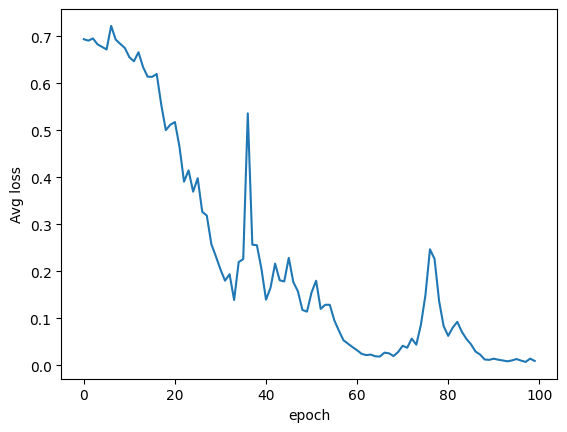

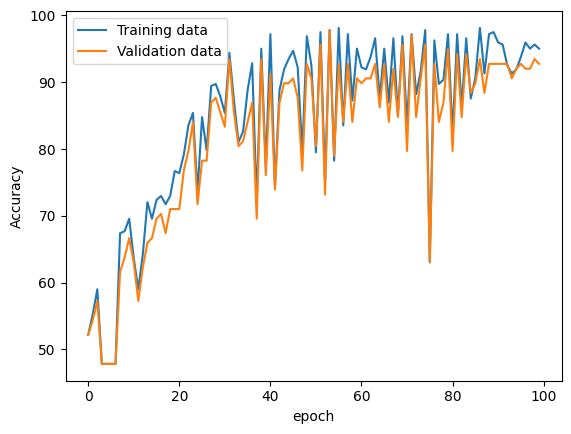

In [9]:
plt.figure()
plt.plot(results['epoch_loss'])
plt.xlabel('epoch')
plt.ylabel('Avg loss')
plt.show()


plt.figure()
plt.plot(results['training_acc'],label='Training data')
plt.plot(results['validation_acc'],label='Validation data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

### 10. Evaluate model

In [10]:
best_model_state=torch.load(cnn_modelfullpath, map_location=device)
model.load_state_dict(best_model_state,strict=True)
model.eval()
print('Fine tune model loaded')

tr_accuracy, tr_est,tr_labels,tr_scores= evaluate_binary_accuracy(model, train_loader)
print(f'Train Binary Accuracy: {tr_accuracy:.4f}')
perf_metrics(tr_labels, tr_est,tr_scores)
print('\n')
v_accuracy,val_est,val_labels, val_scores = evaluate_binary_accuracy(model, val_loader)
print(f'Validation Binary Accuracy: {v_accuracy:.4f}')
perf_metrics(val_labels, val_est,val_scores)
print('\n')
test_accuracy,test_est,test_labels, test_scores = evaluate_binary_accuracy(model, test_loader)
print(f'Test Binary Accuracy: {test_accuracy:.4f}')
perf_metrics(test_labels, test_est,test_scores)

print('Completed')

Fine tune model loaded
Train Binary Accuracy: 97.8261
Confusion Matrix:
[[164   4]
 [  3 151]]
Accuracy: 97.82608695652173
Precision: 97.41935483870968
Sensitivity (Recall): 98.05194805194806
Specificity: 97.61904761904762
F1 Score: 0.9773462783171522
AUC Score: 0.9988017934446506


Validation Binary Accuracy: 97.8261
Confusion Matrix:
[[70  2]
 [ 1 65]]
Accuracy: 97.82608695652173
Precision: 97.01492537313433
Sensitivity (Recall): 98.48484848484848
Specificity: 97.22222222222221
F1 Score: 0.9774436090225564
AUC Score: 0.9972643097643098


Test Binary Accuracy: 95.6522
Confusion Matrix:
[[46  2]
 [ 2 42]]
Accuracy: 95.65217391304348
Precision: 95.45454545454545
Sensitivity (Recall): 95.45454545454545
Specificity: 95.83333333333334
F1 Score: 0.9545454545454546
AUC Score: 0.9971590909090909
Completed
